In [1]:
# Khoruzhii Kirill, 07.06.2024
# Comments enhanced with the assistance of ChatGPT by OpenAI

In [3]:
import numpy as np

import scipy
from scipy import sparse
import scipy.sparse.linalg

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

## Ed

In [4]:
"""

Module to generate the Hamiltonian of the transverse field Ising model.

H = -J sum_i sigma^x_i sigma^x_{i+1} - g sum_i sigma^z i.

Used in the solution of exercise 6.2

"""

Id = sparse.csr_matrix(np.eye(2))
Sx = sparse.csr_matrix([[0., 1.], [1., 0.]])
Sz = sparse.csr_matrix([[1., 0.], [0., -1.]])
Splus = sparse.csr_matrix([[0., 1.], [0., 0.]])
Sminus = sparse.csr_matrix([[0., 0.], [1., 0.]])


def singlesite_to_full(op, i, L):
    op_list = [Id]*L  # = [Id, Id, Id ...] with L entries
    op_list[i] = op
    full = op_list[0]
    for op_i in op_list[1:]:
        full = sparse.kron(full, op_i, format="csr")
    return full


def gen_sx_list(L):
    return [singlesite_to_full(Sx, i, L) for i in range(L)]


def gen_sz_list(L):
    return [singlesite_to_full(Sz, i, L) for i in range(L)]


def gen_hamiltonian_periodic(sx_list, sz_list, g, J=1.):
    """ assumes periodic boundery conditions """
    L = len(sx_list)
    H = sparse.csr_matrix((2**L, 2**L))
    for j in range(L):
        H = H - J *( sx_list[j] * sx_list[(j+1)%L])
        H = H - g * sz_list[j]
    return H


def gen_hamiltonian(sx_list, sz_list, g, J=1.):
    """ assumes open boundery conditions """
    L = len(sx_list)
    H = sparse.csr_matrix((2**L, 2**L))
    for j in range(L-1):
        H = H - J *( sx_list[j] * sx_list[(j+1)%L])
        H = H - g * sz_list[j]
    H = H - g * sz_list[-1]
    return H


## Exercise 7.1: Matrix product state (MPS) basics

In [5]:
# a)
L = 14
g = 1.5 

H = gen_hamiltonian(gen_sx_list(L), gen_sz_list(L), g)
E, gs = sparse.linalg.eigsh(H, k=1, which='SA')

print(f"⟨ψ|ψ⟩ = {np.dot(gs[:,0], gs[:,0]):6f}")

⟨ψ|ψ⟩ = 1.000000


In [6]:
# b)

def compress(psi, L, chimax):
    """
    Compress a wave function 'psi' using singular value decomposition (SVD) to reduce its bond dimensions.
    
    :param psi: Initial state vector of the quantum system, assumed to be a long vector.
    :param L: The number of lattice sites (or spins) in the system.
    :param chimax: Maximum bond dimension allowed after truncation to manage computational resources.
    
    :return: A list of MPS tensors with reduced bond dimensions.
    """
    # Initialize the list to store MPS tensors
    MPS = []
    
    # Initial dummy index α_1 (bond dimension starts at 1)
    chi_prev = 1
    # Reshape 'psi' to begin the iterative bipartitioning and SVD
    psi = psi.reshape((chi_prev, 2**L))
    
    for n in range(1, L + 1):
        # Reshape psi to prepare for SVD, splitting the system into two parts
        dim_Rn = 2**(L - (n - 1))
        psi = psi.reshape((chi_prev * 2, dim_Rn // 2))
        
        # Perform SVD on the reshaped psi
        M_n, lambda_n, psitilde = np.linalg.svd(psi, full_matrices=False)
        
        # Truncate the decomposed matrices to keep only 'chimax' largest singular values
        # to control the size and accuracy of the MPS
        if len(lambda_n) > chimax:
            keep = np.argsort(lambda_n)[::-1][:chimax]
            M_n = M_n[:, keep]
            lambda_n = lambda_n[keep]
            psitilde = psitilde[keep, :]
        
        # Update the bond dimension for the next tensor based on truncation
        chi_next = len(lambda_n)
        
        # Reshape the matrix U from SVD to the tensor format for the MPS component
        M_n = M_n.reshape((chi_prev, 2, chi_next))
        # Append the tensor to the MPS list
        MPS.append(M_n)
        
        # Update psi for the next iteration using the remaining matrices from SVD
        psi = lambda_n[:, np.newaxis] * psitilde
        
        # Update the previous bond dimension for the next iteration
        chi_prev = chi_next
    
    return MPS

In [7]:
# c)

gs_mps_ex = compress(gs, L, int(1e6))
dims = [m.shape[0] for m in gs_mps_ex]

print(f"max dim: {max(dims)}")
print(f"# elemnts: {np.sum([m.size for m in gs_mps_ex])}")
print(dims)

max dim: 128
# elemnts: 43688
[1, 2, 4, 8, 16, 32, 64, 128, 64, 32, 16, 8, 4, 2]


In [8]:
# d)

gs_mps_compr = compress(gs, L, 10)
dims = [m.shape[0] for m in gs_mps_compr]

print(f"max dim: {max(dims)}")
print(f"# elemnts: {np.sum([m.size for m in gs_mps_compr])}")
print(dims)

max dim: 10
# elemnts: 1688
[1, 2, 4, 8, 10, 10, 10, 10, 10, 10, 10, 8, 4, 2]


In [9]:
# e)

def mps_inner_product(stateA, stateB):
    """
    Compute the inner product of two matrix product states (MPS) representing quantum states.
    
    :param stateA: List of MPS tensors for the first quantum state. Each tensor in this list 
                   should have dimensions (bond_dimA[i], phys_dim[i], bond_dimA[i+1]), where 
                   'bond_dimA' are the bond dimensions and 'phys_dim' are the physical dimensions of the state.
    :param stateB: List of MPS tensors for the second quantum state, with dimensions
                   (bond_dimB[i], phys_dim[i], bond_dimB[i+1]), structured similarly to stateA.
                  
    The function uses the complex conjugate of stateA's tensors during the computation. It iteratively
    contracts tensors from the last to the first, ensuring all matching dimensions align properly.
    
    :return: The computed scalar representing the inner product of the two MPS states.
    """
    # Reshape and transpose the last tensor of stateA and stateB for initial contraction
    last_tensorA = np.reshape(np.transpose(stateA[-1], (0, 1, 2)), (stateA[-1].shape[0], stateA[-1].shape[1]))
    last_tensorB = np.reshape(np.transpose(stateB[-1], (0, 1, 2)), (stateB[-1].shape[0], stateB[-1].shape[1]))
    
    # Perform initial tensor contraction between the last tensors of stateA and stateB
    result = np.tensordot(last_tensorB, np.conj(last_tensorA), axes=([1], [1]))
    
    # Iteratively contract the remaining tensors in the list from last to first
    for i in reversed(range(len(stateA)-1)):
        result = np.tensordot(np.conj(stateA[i]), result, axes=([2], [1]))
        result = np.tensordot(stateB[i], result, axes=([1, 2], [1, 2]))
    
    return result.flatten()[0]

In [10]:
# f)

state_up = [np.array([1, 0]).reshape((1, 2, 1)) for _ in range(L)]
print(f"⟨ψ₁|↑...↑⟩ = {mps_inner_product(state_up, gs_mps_ex):.6f}")

⟨ψ₁|↑...↑⟩ = 0.814694


## Exercise 7.2: The AKLT model

In [11]:
# a)
L = 16
M_odd = np.array([[2**(-0.5), 0], [0, -2**(-0.5)]]).reshape((1, 2, 2))
M_even  = np.array([[ 0, 1],  [ 1, 0]]).T.reshape((2, 2, 1))

AKLT = []
# Append M_odd and M_even alternatively, based on half the length of some lattice size L
for i in range(L // 2):
    AKLT.extend([M_odd, M_even])

print(f"⟨AKLT|AKLT⟩ = {mps_inner_product(AKLT, AKLT):.6f}")

⟨AKLT|AKLT⟩ = 1.000000


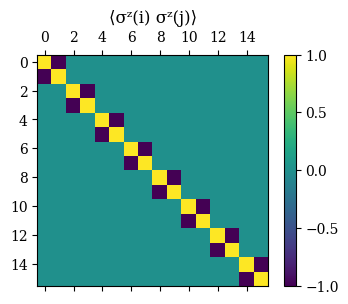

In [12]:
# b)

def apply_operator_to_mps(mps, op, site):
    modified_mps = mps.copy()
    modified_tensor = np.tensordot(modified_mps[site], op.toarray(), axes=([1], [0]))
    modified_tensor = np.transpose(modified_tensor, (0, 2, 1))
    modified_mps[site] = modified_tensor
    return modified_mps

def get_ij_corr(mps, i, j, op):
    mps_i = apply_operator_to_mps(mps, op, i)
    mps_ij = apply_operator_to_mps(mps_i, op, j)
    correlation = mps_inner_product(mps_ij, mps)
    return correlation

res = np.zeros((L,L));
for i in range(L):
    for j in range(L):
        res[i,j] = get_ij_corr(AKLT, i, j, Sz)
fig, ax = plt.subplots(figsize=(4,3))
c = ax.matshow(res)
fig.colorbar(c)
plt.title("⟨σᶻ(i) σᶻ(j)⟩")
plt.show()